In [79]:
import torch
import numpy as np
import pandas as pd
import requests
import json


## Data Cleaning and Exploration

In [96]:
##Features to feed into NN
feature_list = [
    'AwayScore', 'HomeScore','GameTimeLeft', 'HomeFinalScore', 'AwayFinalScore', 'HomeWin',
    
    'hour_sin', 'hour_cos', 'playoff', 'regular', 'AwayPlayOneHot', 'HomePlayOneHot', 'AwayAssist', 'HomeAssist',
    'Home2-pt dunk', 'Away2-pt dunk', 'Home2-pt hook shot', 'Away2-pt hook shot', 'Home2-pt jump shot', 
    'Away2-pt jump shot', 'Home2-pt layup', 'Away2-pt layup', 'Home3-pt jump shot', 'Away3-pt jump shot', 
    'HomeMade2-pt dunk', 'AwayMade2-pt dunk', 'HomeMade2-pt hook shot', 'AwayMade2-pt hook shot', 'HomeMade2-pt jump shot', 
    'AwayMade2-pt jump shot', 'HomeMade2-pt layup', 'AwayMade2-pt layup', 'HomeMade3-pt jump shot', 'AwayMade3-pt jump shot',
    'AwayDRB', 'HomeDRB', 'AwayORB', 'HomeORB', 'AwayFoul', 'HomeFoul', 'AwayBlock', 'HomeBlock', 'AwayViolation', 
    'HomeViolation', 'AwayTurnover', 'HomeTurnover', 'AwayTimeout', 'HomeTimeout', 'AwayFreeThrow', 'HomeFreeThrow', 
    'AwayMadeFreeThrow', 'HomeMadeFreeThrow', 'AwayWonJumpball', 'HomeWonJumpball', 'AwaySub', 'HomeSub', 'GameTimeLeft',
    'AwayAssistTotal', 'HomeAssistTotal', 'Home2-pt dunkTotal', 'Away2-pt dunkTotal', 'Home2-pt hook shotTotal', 
    'Away2-pt hook shotTotal', 'Home2-pt jump shotTotal', 'Away2-pt jump shotTotal', 'Home2-pt layupTotal',
    'Away2-pt layupTotal', 'Home3-pt jump shotTotal', 'Away3-pt jump shotTotal', 'HomeMade2-pt dunkTotal', 
    'AwayMade2-pt dunkTotal', 'HomeMade2-pt hook shotTotal', 'AwayMade2-pt hook shotTotal', 'HomeMade2-pt jump shotTotal',
    'AwayMade2-pt jump shotTotal', 'HomeMade2-pt layupTotal', 'AwayMade2-pt layupTotal', 'HomeMade3-pt jump shotTotal', 
    'AwayMade3-pt jump shotTotal', 'AwayDRBTotal', 'HomeDRBTotal', 'AwayORBTotal', 'HomeORBTotal', 'AwayFoulTotal', 
    'HomeFoulTotal', 'AwayBlockTotal', 'HomeBlockTotal', 'AwayViolationTotal', 'HomeViolationTotal', 'AwayTurnoverTotal',
    'HomeTurnoverTotal', 'AwayTimeoutTotal', 'HomeTimeoutTotal', 'AwayFreeThrowTotal', 'HomeFreeThrowTotal',
    'AwayMadeFreeThrowTotal','HomeMadeFreeThrowTotal', 'AwayWonJumpballTotal', 'HomeWonJumpballTotal', 'AwaySubTotal', 
    'HomeSubTotal','Rk_x', 'Age_x', 'W_x', 'L_x', 'PW_x', 'PL_x', 'MOV_x', 
    'SOS_x', 'SRS_x', 'ORtg_x', 'DRtg_x', 'NRtg_x', 'Pace_x', 'FTr_x', '3PAr_x', 'TS%_x', 'eFG%_x', 'TOV%_x', 
    'ORB%_x', 'FT/FGA_x', 'eFG%.1_x', 'TOV%.1_x', 'DRB%_x', 'FT/FGA.1_x', 'Rk_y', 'Age_y', 'W_y', 'L_y', 
    'PW_y', 'PL_y', 'MOV_y', 'SOS_y', 'SRS_y', 'ORtg_y', 'DRtg_y', 'NRtg_y', 'Pace_y', 'FTr_y', '3PAr_y', 'TS%_y', 
    'eFG%_y', 'TOV%_y', 'ORB%_y', 'FT/FGA_y', 'eFG%.1_y', 'TOV%.1_y', 'DRB%_y', 'FT/FGA.1_y'
]
def process_df(df):
#     df = pd.read_csv(path,  parse_dates=['Date','Time'])
    print('Finished reading in CSV')
#     print(df.columns)
    cols = ['Date', 'URL', 'Location', 'Time', 'WinningTeam', 'Quarter',
       'SecLeft', 'AwayPlay', 'HomePlay','AwayTeam', 'AwayScore', 'HomeTeam',
       'HomeScore', 'ShotType', 'ShotOutcome', 'FoulType', 'Fouler', 'Fouled',
       'FreeThrowShooter', 'FreeThrowOutcome', 'FreeThrowNum', 'TurnoverPlayer', 'TurnoverType', 'TurnoverCause',
       'TurnoverCauser', 'Assister', 'ReboundType', 'Rebounder']
    
    df = df[cols]
    ##Encoding time cyclicly 
    df['hour'] = df["Time"].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/23.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/23.0)

#     ##Encoding game type
#     game_type_one_hot = pd.get_dummies(df['GameType'])
#     df = df.join(game_type_one_hot)

    ##In general it seems better if we make a play than if they make one so let's encode AwayPlay vs HomePlay
    ##0 if NaN and 1 if has some value
    df['AwayPlayOneHot'] = df['AwayPlay'].notnull().astype(int)
    df['HomePlayOneHot'] = df['HomePlay'].notnull().astype(int)

#     ## 1 if assist for certain team 0 otherwise
    df['AwayAssist'] = df['Assister'].notnull().astype(int) * df['AwayPlayOneHot']
    df['HomeAssist'] = df['Assister'].notnull().astype(int) * df['HomePlayOneHot']

#     ##Split the shots into features for home and away team
#     shot_type_oh = pd.get_dummies(df['ShotType'])
#     for col in shot_type_oh.columns:
#         df["Home" + col] = shot_type_oh[col] * df['HomePlayOneHot']
#         df["Away" + col] = shot_type_oh[col] * df['AwayPlayOneHot']
    
    df['2-pt shot'] = df['ShotType'].str.contains('2-pt').fillna(False).astype(int)
    df['3-pt shot'] = df['ShotType'].str.contains('3-pt').fillna(False).astype(int)
    
    for col in ['2-pt shot', '3-pt shot']:
        df["Home " + col] = df[col] * df['HomePlayOneHot']
        df["Away " + col] = df[col] * df['AwayPlayOneHot']
    
    shot_made_oh = pd.get_dummies(df['ShotOutcome'])
    for col in ['2-pt shot', '3-pt shot']:
        df["HomeMade " + col] = df["Home " + col] * shot_made_oh["make"]
        df["AwayMade " + col] = df["Away " + col] * shot_made_oh["make"]

#     ## Same as assists above but for RBS  - also differentiate DRB and ORB
    rbs_type_oh = pd.get_dummies(df['ReboundType'])
    drbs = df['Rebounder'].notnull().astype(int) * rbs_type_oh["defensive"]
    orbs = df['Rebounder'].notnull().astype(int) * rbs_type_oh["offensive"]
    df['AwayDRB'] = drbs * df['AwayPlayOneHot']
    df['HomeDRB'] = drbs * df['HomePlayOneHot']

    df['AwayORB'] = orbs * df['AwayPlayOneHot']
    df['HomeORB'] = orbs * df['HomePlayOneHot']


#     ## away foul is 1 if the away team committed a foul, and is 0 otherwise
    df['AwayFoul'] = df['Fouler'].notnull().astype(int) * df['AwayPlayOneHot']
    df['HomeFoul'] = df['Fouler'].notnull().astype(int) * df['HomePlayOneHot']

#     ## same as above for blocks
#     df['AwayBlock'] = df['Blocker'].notnull().astype(int) * df['AwayPlayOneHot']
#     df['HomeBlock'] = df['Blocker'].notnull().astype(int) * df['HomePlayOneHot']

#     ## same as above for violation
#     df["AwayViolation"] = df["ViolationPlayer"].notnull().astype(int) * df["AwayPlayOneHot"]
#     df["HomeViolation"] = df["ViolationPlayer"].notnull().astype(int) * df["HomePlayOneHot"]

    ## same as above for turnover
    df["AwayTurnover"] = df["TurnoverPlayer"].notnull().astype(int) * df["AwayPlayOneHot"]
    df["HomeTurnover"] = df["TurnoverPlayer"].notnull().astype(int) * df["HomePlayOneHot"]

#     ## same as above for timeout
#     df["AwayTimeout"] = df["TimeoutTeam"].notnull().astype(int) * df["AwayPlayOneHot"]
#     df["HomeTimeout"] = df["TimeoutTeam"].notnull().astype(int) * df["HomePlayOneHot"]

    ## same as shot for free throw
    df['AwayFreeThrow'] = df['FreeThrowShooter'].notnull().astype(int) * df["AwayPlayOneHot"]
    df['HomeFreeThrow'] = df['FreeThrowShooter'].notnull().astype(int) * df["HomePlayOneHot"]

    ft_made_oh = pd.get_dummies(df['FreeThrowOutcome'])
    df['AwayMadeFreeThrow'] = df['AwayFreeThrow'] * ft_made_oh['make']
    df['HomeMadeFreeThrow'] = df['HomeFreeThrow'] * ft_made_oh['make']
    
#     ## same for jumpball
#     df['AwayWonJumpball'] = df['JumpballPoss'].notnull().astype(int) * df['AwayPlayOneHot'][1:].append(pd.Series([0]))
#     df['HomeWonJumpball'] = df['JumpballPoss'].notnull().astype(int) * df['HomePlayOneHot'][1:].append(pd.Series([0])).reset_index().drop(['index'],1)[0]
    
#     ## Same for substitution
#     df['AwaySub'] = df['EnterGame'].notnull().astype(int) * df['AwayPlayOneHot']
#     df['HomeSub'] = df['EnterGame'].notnull().astype(int) * df['HomePlayOneHot']
    
    ##Normalize other columns that we are keeping
    df['GameTimeLeft'] = (48 * 60) - df['Quarter'] * (12 * 60) + df['SecLeft'] ## doesn't account for OT
#     df['GameTimeLeft'] /= 2880
    max_time = 48*60
    df['GameTimeLeftSin'] = df['GameTimeLeft'].apply(lambda x: np.sin(2 * np.pi*x / max_time))
    df['GameTimeLeftCos'] = df['GameTimeLeft'].apply(lambda x: np.cos(2 * np.pi*x / max_time))
    
    ##Temp using mean 100 std deviation 15 for final scores - somewhat close to real averages esp across older data
    df['AwayScore'] = (df['AwayScore'] - 100) / 15
    df['HomeScore'] = (df['HomeScore'] - 100) / 15

    ##Aggregate game statistics
    df = df.sort_values(by=['Date','HomeTeam','GameTimeLeft'], ascending=[True,True,False], kind='mergesort').reset_index()
    df.drop(['index'], 1, inplace=True)
#     to_accumulate = [
#         'AwayAssist', 'HomeAssist', 'Home2-pt dunk', 'Away2-pt dunk', 'Home2-pt hook shot', 'Away2-pt hook shot', 
#         'Home2-pt jump shot', 'Away2-pt jump shot', 'Home2-pt layup', 'Away2-pt layup', 'Home3-pt jump shot', 
#         'Away3-pt jump shot', 'HomeMade2-pt dunk', 'AwayMade2-pt dunk', 'HomeMade2-pt hook shot', 
#         'AwayMade2-pt hook shot', 'HomeMade2-pt jump shot', 'AwayMade2-pt jump shot', 
#         'HomeMade2-pt layup', 'AwayMade2-pt layup', 'HomeMade3-pt jump shot', 'AwayMade3-pt jump shot', 
#         'AwayDRB', 'HomeDRB', 'AwayORB', 'HomeORB','AwayFoul', 'HomeFoul', 'AwayBlock', 'HomeBlock', 
#         'AwayViolation', 'HomeViolation', 'AwayTurnover', 'HomeTurnover', 'AwayTimeout', 
#         'HomeTimeout', 'AwayFreeThrow', 'HomeFreeThrow', 'AwayMadeFreeThrow', 
#         'HomeMadeFreeThrow', 'AwayWonJumpball', 'HomeWonJumpball', 'AwaySub', 'HomeSub'
#     ]
    to_accumulate = [
        'Home 2-pt shot', 'Away 2-pt shot', 'HomeMade 2-pt shot', 'AwayMade 2-pt shot',
        'Home 3-pt shot', 'Away 3-pt shot', 'HomeMade 3-pt shot', 'AwayMade 3-pt shot',
        'AwayTurnover', 'HomeTurnover', 'AwayFreeThrow', 'HomeFreeThrow', 'AwayMadeFreeThrow', 
        'HomeMadeFreeThrow','AwayAssist', 'HomeAssist','AwayDRB', 'HomeDRB', 'AwayORB', 'HomeORB','AwayFoul', 'HomeFoul',
    ]
    
    accumulated = []
    for col in to_accumulate:
        df[col + "Total"] = df.groupby(['URL'])[col].cumsum()
        accumulated.append(col + "Total")
    df['HomeCurrentTotal'] = df['HomeMade 2-pt shotTotal'] * 2 + df['HomeMade 3-pt shotTotal' * 3] + df['HomeMadeFreeThrowTotal']
    df['AwayCurrentTotal'] = df['AwayMade 2-pt shotTotal'] * 2 + df['AwayMade 3-pt shotTotal' * 3] + df['AwayMadeFreeThrowTotal']
    accumulated.append('HomeCurrentTotal')
    accumulated.append('AwayCurrentTotal')

    for col in accumulated:
        mean = np.mean(df.groupby(['URL'])[col].max())
        std = np.std(df.groupby(['URL'])[col].max())
        df[col] = (df[col] - mean) / std
        
    ## add ground truth labels we will try to predict
    finalHomeScores = df.groupby(['URL'])["HomeScore"].max()
    finalAwayScores = df.groupby(['URL'])["AwayScore"].max()

    sizes = df.groupby(['URL']).size()
    homeScoresCol = np.array([])
    awayScoresCol = np.array([])
    for i in range(len(sizes)):
        homeScoresCol = np.concatenate((homeScoresCol, np.full(sizes[i], finalHomeScores[i])))
        awayScoresCol = np.concatenate((awayScoresCol, np.full(sizes[i], finalAwayScores[i])))

    df['HomeFinalScore'] = homeScoresCol
    df['AwayFinalScore'] = awayScoresCol
    
    df['HomeWin'] = (df['HomeFinalScore'] > df['AwayFinalScore']).astype(int)
    
    print('Finished processsing PBP Data')
    return df

def add_team_stats(df, team_path):
    return df

    print('Adding Team Stats')
    teams_df = pd.read_csv(team_path)
    abbrevs = []
    teams = []
    with open('teams.json', 'r') as f:
        teams = json.load(f)
    for teamname in teams_df['Team']:
        if teamname[-1] == '*':
            teamname = teamname[:-1]
        for i in range(len(teams)):
            if teams[i]['teamName'] == teamname:
                abbrev = teams[i]['abbreviation']
                if abbrev == 'BKN':
                    abbrevs.append('BRK')
                elif abbrev == 'PHX':
                    abbrevs.append('PHO')
                elif abbrev == 'CHA':
                    abbrevs.append('CHO')
                else:
                    abbrevs.append(teams[i]['abbreviation'])
    teams_df['Names'] = abbrevs
    teams_df.drop(['Team','Arena','Attend.','Attend./G'],1, inplace=True)
    columns = teams_df.columns
    df = df.merge(teams_df,left_on = 'AwayTeam',right_on = 'Names',how = 'left').reset_index()
    df = df.merge(teams_df,left_on = 'HomeTeam',right_on = 'Names',how = 'left').reset_index()
    for col in columns:
        if col == "Names":
            continue
        mean = np.mean(teams_df[col])
        std = np.std(teams_df[col])
        df[col + '_x'] = (df[col + '_x'] - mean) / std
        df[col + '_y'] = (df[col + '_y'] - mean) / std
    return df

In [99]:
original_df1 = pd.read_csv("NBA_PBP_2019-20.csv",  parse_dates=['Date','Time'])
original_df2 = pd.read_csv("NBA_PBP_2018-19.csv",  parse_dates=['Date','Time'])

original_df = pd.concat([original_df1, original_df2])

# original_df = pd.read_csv("NBA_PBP_2020-21.csv",  parse_dates=['Date','Time'])


KeyboardInterrupt: 

In [ ]:
len(original_df)

In [83]:
df = process_df(original_df)
df = add_team_stats(df, "team2019.csv")
# df.drop(df.columns.difference(feature_list+ ['HomeTeam','AwayTeam','Date']), 1, inplace=True)
df

Finished reading in CSV


/Users/calvingrewal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calvingrewal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calvingrewal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

Finished processsing PBP Data


,Date,URL,Location,Time,WinningTeam,Quarter,SecLeft,AwayPlay,HomePlay,AwayTeam,...,HomeAssistTotal,AwayDRBTotal,HomeDRBTotal,AwayORBTotal,HomeORBTotal,AwayFoulTotal,HomeFoulTotal,HomeFinalScore,AwayFinalScore,HomeWin
0,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,720,Jump ball: J. Wiseman vs. D. Jordan (J. Harris...,NaN,GSW,...,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,1.666667,-0.066667,1
1,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,710,NaN,Turnover by D. Jordan (bad pass),GSW,...,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,1.666667,-0.066667,1
2,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,698,Shooting foul by K. Irving (drawn by S. Curry),NaN,GSW,...,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1
3,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,698,S. Curry makes free throw 1 of 2,NaN,GSW,...,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1
4,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,698,S. Curry makes free throw 2 of 2,NaN,GSW,...,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1
5,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,682,NaN,K. Irving makes 2-pt jump shot from 22 ft (ass...,GSW,...,-4.872347,-6.987293,-6.637415,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1
6,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,671,J. Wiseman makes 2-pt dunk from 1 ft (assist b...,NaN,GSW,...,-4.872347,-6.987293,-6.637415,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1
7,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,649,NaN,K. Durant makes 3-pt jump shot from 26 ft (ass...,GSW,...,-4.667824,-6.987293,-6.637415,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1
8,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,631,A. Wiggins misses 3-pt jump shot from 24 ft,NaN,GSW,...,-4.667824,-6.987293,-6.637415,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1
9,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,625,NaN,Defensive rebound by J. Harris,GSW,...,-4.667824,-6.987293,-6.459315,-3.682666,-3.413380,-4.673160,-4.427780,1.666667,-0.066667,1


In [84]:
cols = ['URL', 'Location', 'Time', 'WinningTeam', 'Quarter',
       'SecLeft', 'AwayTeam', 'AwayScore', 'HomeTeam',
       'HomeScore', 'ShotType', 'ShotOutcome', 'FoulType', 'Fouler', 'Fouled',
       'FreeThrowShooter', 'FreeThrowOutcome', 'FreeThrowNum', 'TurnoverPlayer', 'TurnoverType', 'TurnoverCause',
       'TurnoverCauser','Assister', 'ReboundType', 'Rebounder']
df[cols]

,URL,Location,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayScore,HomeTeam,HomeScore,...,FreeThrowShooter,FreeThrowOutcome,FreeThrowNum,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,Assister,ReboundType,Rebounder
0,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,720,GSW,-6.666667,BRK,-6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,710,GSW,-6.666667,BRK,-6.666667,...,NaN,NaN,NaN,D. Jordan - jordade01,bad pass,NaN,NaN,NaN,NaN,NaN
2,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,698,GSW,-6.666667,BRK,-6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,698,GSW,-6.600000,BRK,-6.666667,...,S. Curry - curryst01,make,1 of 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,698,GSW,-6.533333,BRK,-6.666667,...,S. Curry - curryst01,make,2 of 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,682,GSW,-6.533333,BRK,-6.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K. Durant - duranke01,NaN,NaN
6,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,671,GSW,-6.400000,BRK,-6.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A. Wiggins - wiggian01,NaN,NaN
7,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,649,GSW,-6.400000,BRK,-6.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J. Harris - harrijo01,NaN,NaN
8,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,631,GSW,-6.400000,BRK,-6.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,1,625,GSW,-6.400000,BRK,-6.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,defensive,J. Harris - harrijo01


In [95]:
len(df.columns), df.columns

(85,
 Index(['Date', 'URL', 'Location', 'Time', 'WinningTeam', 'Quarter', 'SecLeft',
        'AwayPlay', 'HomePlay', 'AwayTeam', 'AwayScore', 'HomeTeam',
        'HomeScore', 'ShotType', 'ShotOutcome', 'FoulType', 'Fouler', 'Fouled',
        'FreeThrowShooter', 'FreeThrowOutcome', 'FreeThrowNum',
        'TurnoverPlayer', 'TurnoverType', 'TurnoverCause', 'TurnoverCauser',
        'Assister', 'ReboundType', 'Rebounder', 'hour', 'hour_sin', 'hour_cos',
        'AwayPlayOneHot', 'HomePlayOneHot', 'AwayAssist', 'HomeAssist',
        '2-pt shot', '3-pt shot', 'Home 2-pt shot', 'Away 2-pt shot',
        'Home 3-pt shot', 'Away 3-pt shot', 'HomeMade 2-pt shot',
        'AwayMade 2-pt shot', 'HomeMade 3-pt shot', 'AwayMade 3-pt shot',
        'AwayDRB', 'HomeDRB', 'AwayORB', 'HomeORB', 'AwayFoul', 'HomeFoul',
        'AwayTurnover', 'HomeTurnover', 'AwayFreeThrow', 'HomeFreeThrow',
        'AwayMadeFreeThrow', 'HomeMadeFreeThrow', 'GameTimeLeft',
        'GameTimeLeftSin', 'GameTimeLeftCos', '

In [77]:
len(df)

1153781

In [86]:
df.to_csv("../app_nba_prediction/2020-21pbpfeatures.csv",index=False)

In [89]:
df.iloc[510:516]

,Date,URL,Location,Time,WinningTeam,Quarter,SecLeft,AwayPlay,HomePlay,AwayTeam,...,HomeAssistTotal,AwayDRBTotal,HomeDRBTotal,AwayORBTotal,HomeORBTotal,AwayFoulTotal,HomeFoulTotal,HomeFinalScore,AwayFinalScore,HomeWin
510,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,4,8,Offensive rebound by D. Lee,NaN,GSW,...,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,1.666667,-0.066667,1
511,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,4,7,M. Mulder makes 3-pt jump shot from 26 ft (ass...,NaN,GSW,...,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,1.666667,-0.066667,1
512,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,4,0,End of 4th quarter,NaN,GSW,...,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,1.666667,-0.066667,1
513,2020-12-22,/boxscores/202012220BRK.html,Barclays Center Brooklyn New York,2021-05-08 19:00:00,BRK,4,0,End of Game,NaN,GSW,...,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,1.666667,-0.066667,1
514,2020-12-22,/boxscores/202012220LAL.html,STAPLES Center Los Angeles California,2021-05-08 22:00:00,LAC,1,720,Jump ball: S. Ibaka vs. A. Davis (L. James gai...,NaN,LAC,...,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,0.600000,1.066667,0
515,2020-12-22,/boxscores/202012220LAL.html,STAPLES Center Los Angeles California,2021-05-08 22:00:00,LAC,1,700,NaN,A. Davis misses 2-pt jump shot from 15 ft,LAC,...,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,0.600000,1.066667,0


In [78]:
# df.to_csv("2018-20pbpfeatures_long.csv",index=False)

In [71]:
df

,Date,URL,Location,Time,WinningTeam,Quarter,SecLeft,AwayPlay,HomePlay,AwayTeam,...,HomeAssistTotal,AwayDRBTotal,HomeDRBTotal,AwayORBTotal,HomeORBTotal,AwayFoulTotal,HomeFoulTotal,HomeFinalScore,AwayFinalScore,HomeWin
0,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,720,Jump ball: J. McGee vs. I. Zubac (L. James gai...,NaN,LAL,...,-5.081362,-6.347203,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
1,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,707,L. James makes 2-pt layup from 3 ft (assist by...,NaN,LAL,...,-5.081362,-6.347203,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
2,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,700,NaN,L. Shamet misses 3-pt jump shot from 27 ft,LAL,...,-5.081362,-6.347203,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
3,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,698,Defensive rebound by A. Davis,NaN,LAL,...,-5.081362,-6.173513,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
4,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,683,D. Green makes 3-pt jump shot from 25 ft (assi...,NaN,LAL,...,-5.081362,-6.173513,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
5,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,660,NaN,P. Beverley misses 3-pt jump shot from 27 ft,LAL,...,-5.081362,-6.173513,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
6,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,657,Defensive rebound by L. James,NaN,LAL,...,-5.081362,-5.999823,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
7,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,647,A. Davis misses 2-pt jump shot from 19 ft,NaN,LAL,...,-5.081362,-5.999823,-6.707985,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
8,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,645,NaN,Defensive rebound by Team,LAL,...,-5.081362,-5.999823,-6.529161,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1
9,2019-10-22,/boxscores/201910220LAC.html,STAPLES Center Los Angeles California,2021-05-07 22:30:00,LAC,1,629,NaN,K. Leonard misses 2-pt jump shot from 14 ft,LAL,...,-5.081362,-5.999823,-6.529161,-3.386662,-3.530054,-4.566096,-4.487027,0.800000,0.133333,1


In [70]:
df['HomePlayOneHot'][1:].append(pd.Series([0])).reset_index().drop(['index'],1)[0]


0         0
1         1
2         0
3         0
4         1
5         0
6         0
7         1
8         1
9         1
10        1
11        0
12        1
13        0
14        1
15        1
16        0
17        1
18        0
19        0
20        0
21        0
22        0
23        1
24        1
25        0
26        0
27        0
28        1
29        1
         ..
539235    1
539236    1
539237    0
539238    1
539239    1
539240    0
539241    0
539242    0
539243    1
539244    0
539245    1
539246    0
539247    0
539248    0
539249    1
539250    0
539251    1
539252    0
539253    1
539254    0
539255    1
539256    1
539257    1
539258    1
539259    1
539260    0
539261    1
539262    0
539263    0
539264    0
Name: 0, Length: 539265, dtype: int64

In [8]:
df.isna().sum()

Date                      0
AwayTeam                  0
AwayScore                 0
HomeTeam                  0
HomeScore                 0
hour_sin                  0
hour_cos                  0
playoff                   0
regular                   0
AwayPlayOneHot            0
HomePlayOneHot            0
AwayAssist                0
HomeAssist                0
Home2-pt dunk             0
Away2-pt dunk             0
Home2-pt hook shot        0
Away2-pt hook shot        0
Home2-pt jump shot        0
Away2-pt jump shot        0
Home2-pt layup            0
Away2-pt layup            0
Home3-pt jump shot        0
Away3-pt jump shot        0
HomeMade2-pt dunk         0
AwayMade2-pt dunk         0
HomeMade2-pt hook shot    0
AwayMade2-pt hook shot    0
HomeMade2-pt jump shot    0
AwayMade2-pt jump shot    0
HomeMade2-pt layup        0
                         ..
ORB%_x                    0
FT/FGA_x                  0
eFG%.1_x                  0
TOV%.1_x                  0
DRB%_x              

In [19]:
df['ShotType'].str.contains('2-pt').fillna(False).astype(int)

0         0
1         1
2         0
3         1
4         1
5         0
6         1
7         0
8         0
9         0
10        1
11        0
12        0
13        0
14        0
15        0
16        1
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        1
29        0
         ..
539235    1
539236    0
539237    0
539238    0
539239    0
539240    0
539241    0
539242    0
539243    1
539244    1
539245    0
539246    0
539247    0
539248    0
539249    0
539250    0
539251    0
539252    0
539253    0
539254    1
539255    0
539256    0
539257    0
539258    0
539259    0
539260    1
539261    0
539262    0
539263    0
539264    0
Name: ShotType, Length: 539265, dtype: int64

In [10]:
for name in pd.get_dummies(df['AwayTeam']).columns:
    if name not in set(teams_df['Names']):
        print(name)

NameError: name 'teams_df' is not defined

In [12]:
calvin = pd.read_csv('2019pbpfeatures.csv')
calvin.head()

,Date,AwayTeam,AwayScore,HomeTeam,HomeScore,hour_sin,hour_cos,playoff,regular,AwayPlayOneHot,...,3PAr_y,TS%_y,eFG%_y,TOV%_y,ORB%_y,FT/FGA_y,eFG%.1_y,TOV%.1_y,DRB%_y,FT/FGA.1_y
0,2019-10-22,LAL,-6.666667,LAC,-6.666667,-0.269797,0.962917,0,1,1,...,-0.215859,0.896664,0.479271,-0.271315,0.653578,1.786168,-1.38392,-0.537824,0.081352,0.227588
1,2019-10-22,LAL,-6.533333,LAC,-6.666667,-0.269797,0.962917,0,1,1,...,-0.215859,0.896664,0.479271,-0.271315,0.653578,1.786168,-1.38392,-0.537824,0.081352,0.227588
2,2019-10-22,LAL,-6.533333,LAC,-6.666667,-0.269797,0.962917,0,1,0,...,-0.215859,0.896664,0.479271,-0.271315,0.653578,1.786168,-1.38392,-0.537824,0.081352,0.227588
3,2019-10-22,LAL,-6.533333,LAC,-6.666667,-0.269797,0.962917,0,1,1,...,-0.215859,0.896664,0.479271,-0.271315,0.653578,1.786168,-1.38392,-0.537824,0.081352,0.227588
4,2019-10-22,LAL,-6.333333,LAC,-6.666667,-0.269797,0.962917,0,1,1,...,-0.215859,0.896664,0.479271,-0.271315,0.653578,1.786168,-1.38392,-0.537824,0.081352,0.227588


In [29]:
df['GameTimeLeft'].min(), df['GameTimeLeft'].max()

(-0.5, 1.0)

In [41]:
from matplotlib import pyplot as plt


In [44]:
# i: {0...22}
train_loss = {
    (0, 0): 0.9,
    (0, 10): 0.6,
    (0, 20): 0.47,
    (1, 0): 0.44,
    (1, 10): 0.35,
    (1, 20): 0.30,
}

In [52]:
keys = train_loss.keys()
vals = train_loss.values()
keys,vals

(dict_keys([(0, 0), (0, 10), (0, 20), (1, 0), (1, 10), (1, 20)]),
 dict_values([0.9, 0.6, 0.47, 0.44, 0.35, 0.3]))

In [54]:
list(train_loss.items())

[((0, 0), 0.9),
 ((0, 10), 0.6),
 ((0, 20), 0.47),
 ((1, 0), 0.44),
 ((1, 10), 0.35),
 ((1, 20), 0.3)]

Text(0, 0.5, 'MSE Loss')

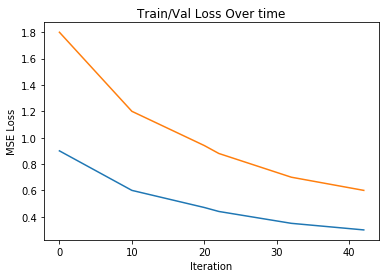

In [63]:
max_i = 22 #len(train_urls)

x = list(map(lambda p: p[0]*max_i + p[1], train_loss.keys()))
y = list(train_loss.values())

x_val = list(map(lambda p: p[0]*max_i + p[1], train_loss.keys()))
y_val = np.array(list(train_loss.values())) * 2

plt.plot(x, y)
plt.plot(x_val, y_val)
plt.title('Train/Val Loss Over time')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')

In [91]:
df.groupby('URL').size().tolist()

[514,
 494,
 469,
 487,
 464,
 538,
 478,
 471,
 450,
 469,
 495,
 471,
 457,
 452,
 492,
 462,
 463,
 460,
 495,
 485,
 515,
 561,
 515,
 465,
 496,
 500,
 483,
 545,
 505,
 530,
 483,
 457,
 432,
 416,
 481,
 462,
 493,
 448,
 464,
 478,
 527,
 478,
 426,
 433,
 467,
 507,
 447,
 432,
 439,
 466,
 502,
 420,
 447,
 499,
 465,
 506,
 501,
 456,
 492,
 445,
 469,
 479,
 461,
 456,
 462,
 427,
 506,
 456,
 458,
 461,
 440,
 461,
 495,
 478,
 461,
 482,
 447,
 482,
 466,
 421,
 502,
 468,
 460,
 503,
 494,
 441,
 516,
 463,
 432,
 426,
 478,
 450,
 492,
 472,
 437,
 447,
 495,
 443,
 477,
 505,
 456,
 512,
 436,
 448,
 463,
 493,
 457,
 450,
 447,
 491,
 437,
 429,
 450,
 489,
 439,
 453,
 486,
 499,
 443,
 436,
 472,
 475,
 494,
 427,
 411,
 439,
 461,
 478,
 458,
 461,
 449,
 467,
 439,
 441,
 448,
 498,
 452,
 493,
 497,
 434,
 461,
 484,
 495,
 443,
 458,
 411,
 459,
 443,
 450,
 455,
 421,
 452,
 471,
 417,
 426,
 483,
 464,
 466,
 532,
 488,
 456,
 408,
 486,
 427,
 449,
 451,
 467

In [93]:
cols = ['GameTimeLeftSin', 'GameTimeLeftCos', 'Home 2-pt shot', 'Away 2-pt shot',
        'Home 3-pt shot', 'Away 3-pt shot', 'HomeMade 2-pt shot',
        'AwayMade 2-pt shot', 'HomeMade 3-pt shot', 'AwayMade 3-pt shot',
        'AwayDRB', 'HomeDRB', 'AwayORB', 'HomeORB',
        'AwayFoul', 'HomeFoul',
        'AwayTurnover', 'HomeTurnover', 'AwayFreeThrow', 'HomeFreeThrow',
        'AwayMadeFreeThrow', 'HomeMadeFreeThrow',
        'Home 2-pt shotTotal', 'Away 2-pt shotTotal', 'HomeMade 2-pt shotTotal',
        'AwayMade 2-pt shotTotal', 'Home 3-pt shotTotal', 'Away 3-pt shotTotal',
        'HomeMade 3-pt shotTotal', 'AwayMade 3-pt shotTotal',
        'AwayTurnoverTotal', 'HomeTurnoverTotal', 'AwayFreeThrowTotal',
        'HomeFreeThrowTotal', 'AwayMadeFreeThrowTotal',
        'HomeMadeFreeThrowTotal', 'AwayAssistTotal', 'HomeAssistTotal',
        'AwayDRBTotal', 'HomeDRBTotal', 'AwayORBTotal', 'HomeORBTotal',
        'AwayFoulTotal', 'HomeFoulTotal', 'AwayScore', 'HomeScore']

In [94]:
df[cols].iloc[510:520]

,GameTimeLeftSin,GameTimeLeftCos,Home 2-pt shot,Away 2-pt shot,Home 3-pt shot,Away 3-pt shot,HomeMade 2-pt shot,AwayMade 2-pt shot,HomeMade 3-pt shot,AwayMade 3-pt shot,...,AwayAssistTotal,HomeAssistTotal,AwayDRBTotal,HomeDRBTotal,AwayORBTotal,HomeORBTotal,AwayFoulTotal,HomeFoulTotal,AwayScore,HomeScore
510,1.745241e-02,0.999848,0,0,0,0,0,0,0,0,...,0.092494,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,-0.266667,1.666667
511,1.527104e-02,0.999883,0,0,0,1,0,0,0,1,...,0.304925,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,-0.066667,1.666667
512,0.000000e+00,1.000000,0,0,0,0,0,0,0,0,...,0.304925,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,-0.066667,1.666667
513,0.000000e+00,1.000000,0,0,0,0,0,0,0,0,...,0.304925,-0.168316,-0.035062,1.555178,1.925182,0.626719,-0.773223,1.754384,-0.066667,1.666667
514,-2.449294e-16,1.000000,0,0,0,0,0,0,0,0,...,-5.218283,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,-6.666667,-6.666667
515,-4.361939e-02,0.999048,1,0,0,0,0,0,0,0,...,-5.218283,-5.076870,-6.987293,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,-6.666667,-6.666667
516,-5.015716e-02,0.998741,0,0,0,0,0,0,0,0,...,-5.218283,-5.076870,-6.799395,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,-6.666667,-6.666667
517,-6.975647e-02,0.997564,0,1,0,0,0,1,0,0,...,-5.218283,-5.076870,-6.799395,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,-6.533333,-6.666667
518,-1.240345e-01,0.992278,0,0,1,0,0,0,0,0,...,-5.218283,-5.076870,-6.799395,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,-6.533333,-6.666667
519,-1.283629e-01,0.991727,0,0,0,0,0,0,0,0,...,-5.218283,-5.076870,-6.611497,-6.637415,-3.682666,-3.413380,-4.916906,-4.427780,-6.533333,-6.666667
